In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)
#path
%cd /content/gdrive/My Drive/Research/UOH/AGenericALSSL_ESwA2023/

Mounted at /content/gdrive/
/content/gdrive/My Drive/Research/UOH/AGenericALSSL_ESwA2023


RUNS: 1 FOLDS: 5 

------------------------------
OBESIDAD
svm
rf
nb-multinomial
------------------------------
OBESIDAD_TIPOS
svm
rf
nb-multinomial
------------------------------
FUMADOR
svm
rf
nb-multinomial
------------------------------
AMAZON
svm
rf
nb-multinomial
------------------------------
IMDB
svm
rf
nb-multinomial
------------------------------
YELP
svm
rf
nb-multinomial


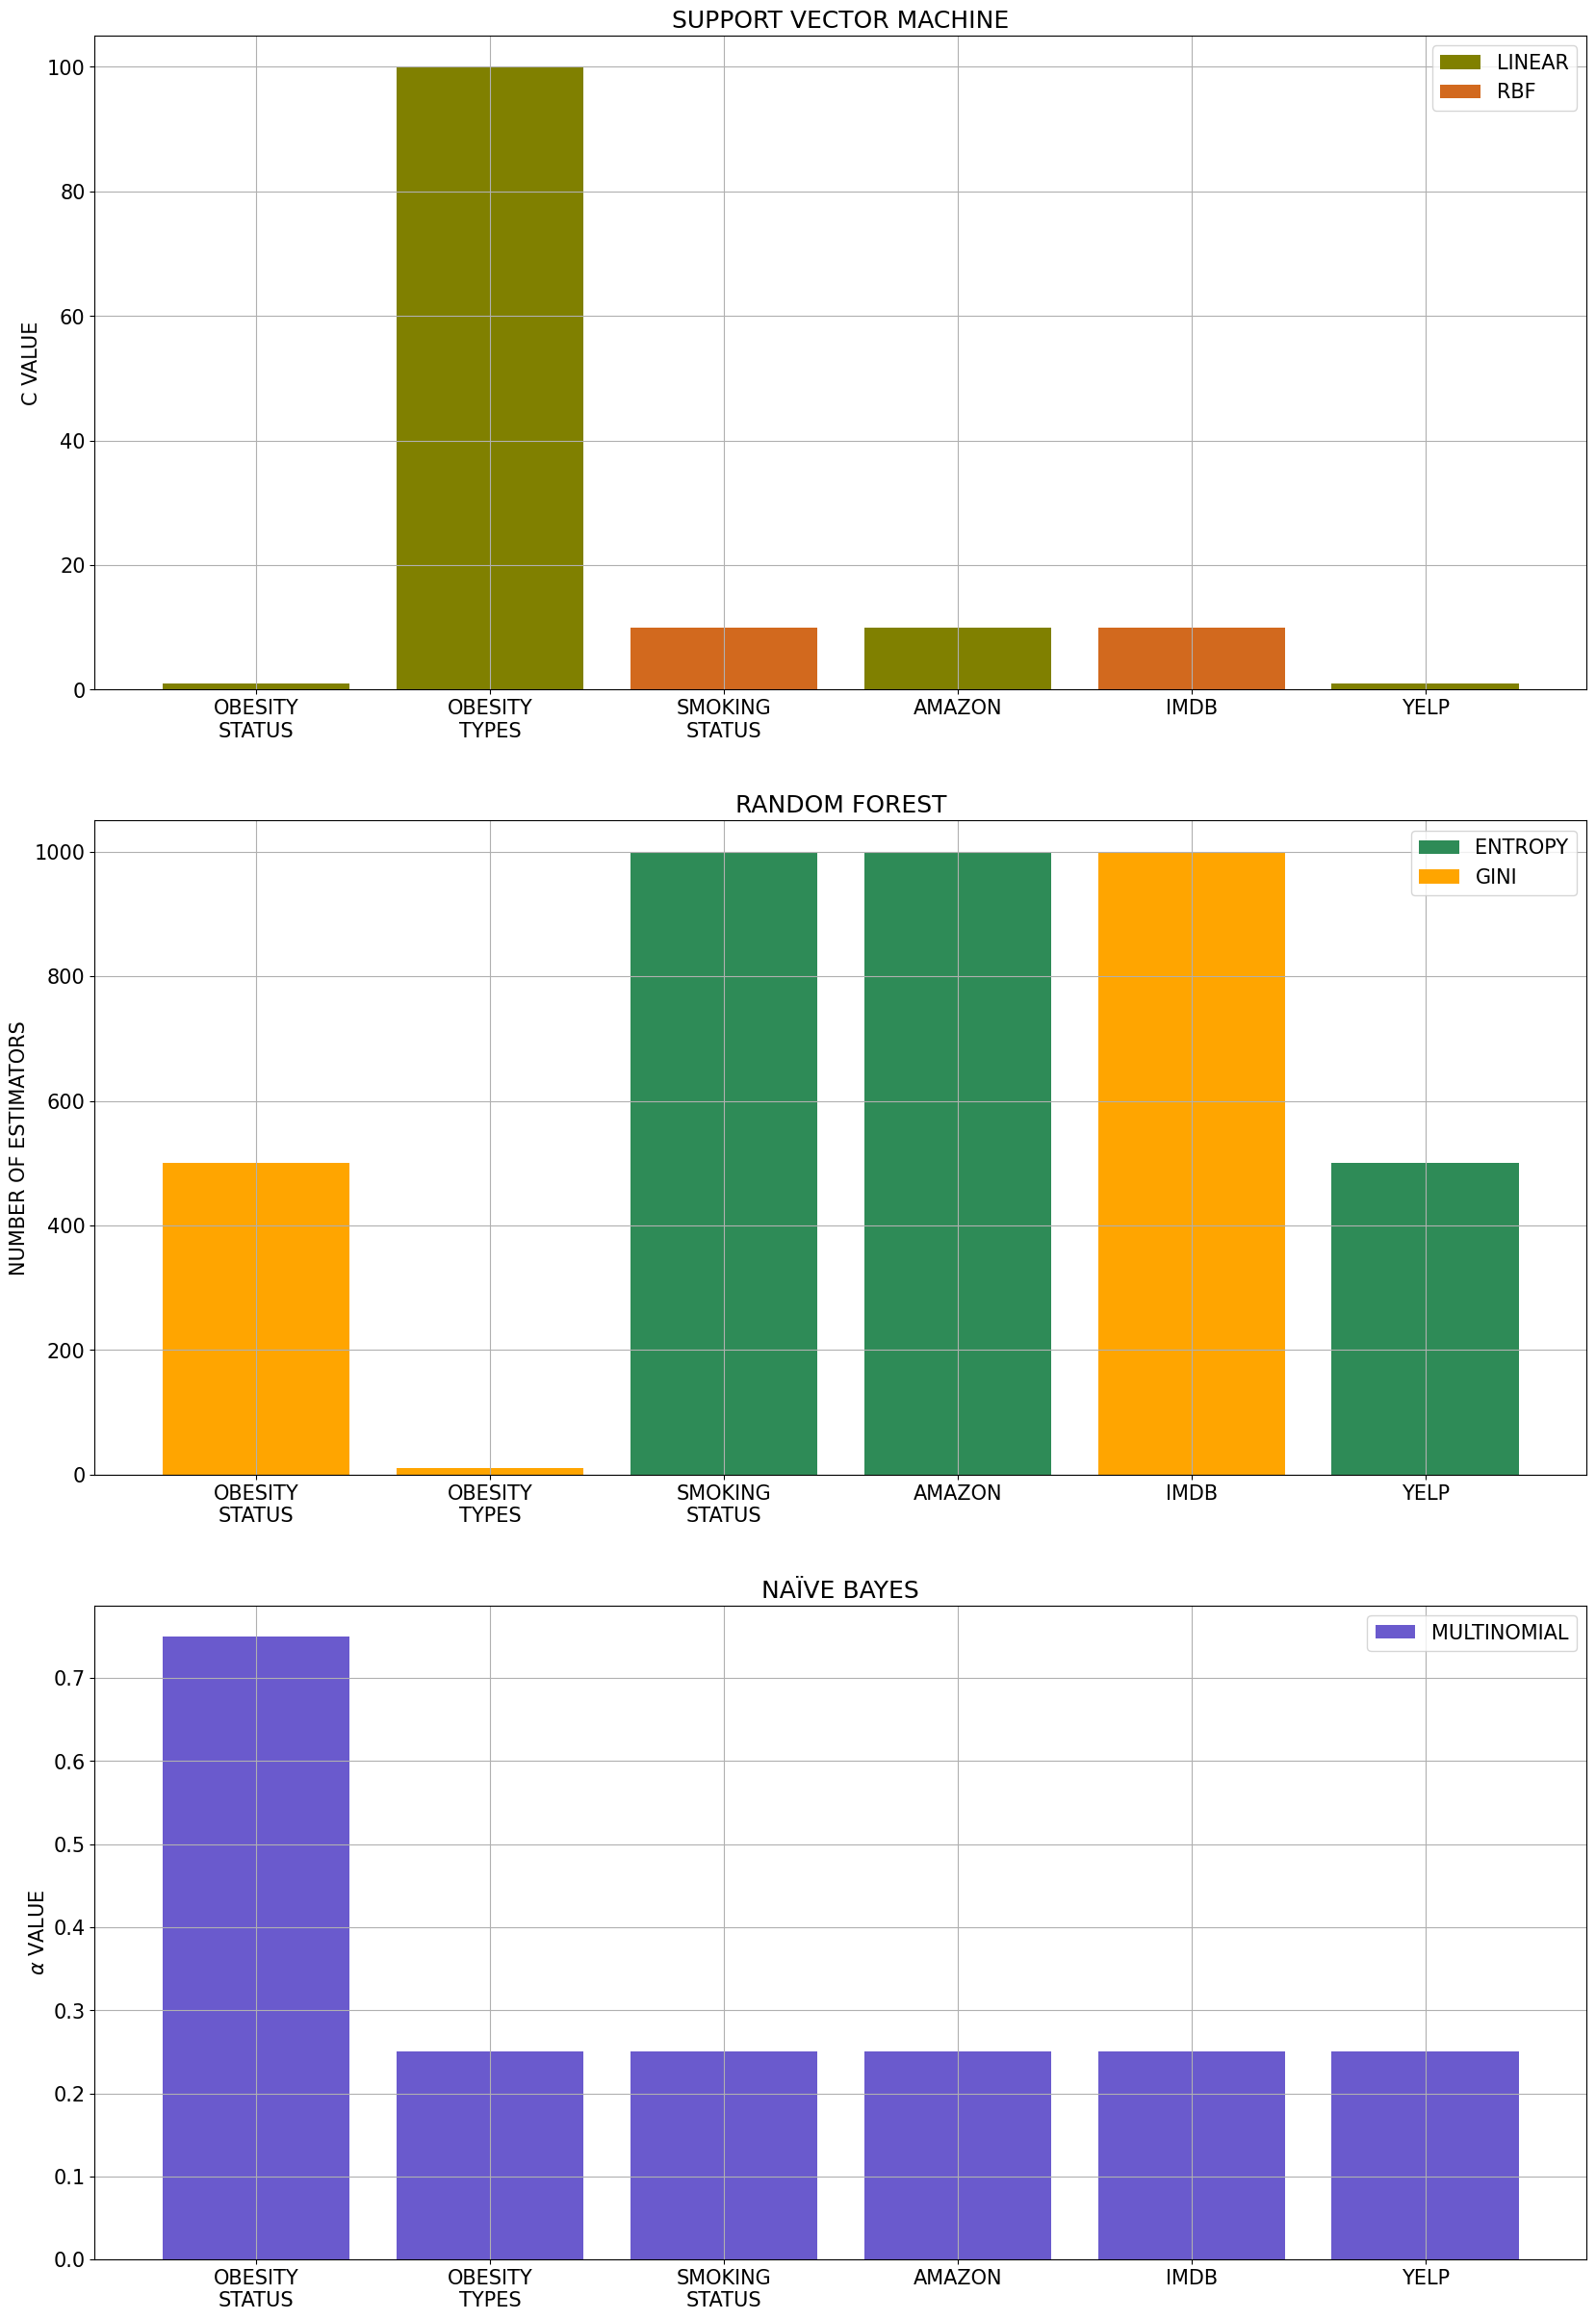

In [2]:
#Hyperparameters
import warnings
warnings.filterwarnings("ignore")

import os
import pickle
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import numpy as np
from collections import defaultdict
from matplotlib import pylab
from collections import Counter
import matplotlib
from matplotlib.patches import Patch

FONTSIZE = 15
matplotlib.rcParams.update({'font.size': FONTSIZE})
pylab.rcParams["legend.facecolor"] = "white"
pylab.rcParams['figure.facecolor'] = "white"

DOMAIN = 'texts'

FILENAMES = ['OBESIDAD', 'OBESIDAD_TIPOS', 'FUMADOR', 'AMAZON', 'IMDB', 'YELP']

FILENAMES_ENG = ['OBESITY\nSTATUS', 'OBESITY\nTYPES', 'SMOKING\nSTATUS', 'AMAZON', 'IMDB', 'YELP']

MODELS = ['svm', 'rf', 'nb-multinomial'] #run twice (classic and bert)
#MODELS = ['bert']

titles = {'svm': 'SUPPORT VECTOR MACHINE', 'rf': 'RANDOM FOREST', 'nb-multinomial': 'NAÏVE BAYES'}
colors = {'LINEAR' : 'olive', 'RBF': 'chocolate' ,
          'GINI': 'orange', 'ENTROPY': 'seagreen',
          'MULTINOMIAL': 'slateblue'}

RUNS = 1
FOLDS = 5

fig = pylab.figure(1, figsize=(20,30))

print('RUNS:', RUNS, 'FOLDS:', FOLDS, '\n')

for FILENAME in FILENAMES:

  baseline_results = {}
  print('-'*30)
  print(FILENAME)

  for model in MODELS:

    params_aux = defaultdict(list)
    params = defaultdict(list)

    print(model)

    if model != 'bert':
      GRID_PARAMS = True
    else:
      GRID_PARAMS = False

    results = defaultdict(list)
    for r in range(RUNS):
      for k in range(FOLDS):
        with open( os.path.join( os.getcwd(), DOMAIN, 'out', 'RESULTS', FILENAME, model, FILENAME+'_results_'+model+'_r'+str(r+1)+'_f'+str(k+1)+'_p'+str(GRID_PARAMS)+'.pkl' ), 'rb') as a:
          results_aux = pickle.load(a)

          params_aux[model+'_params'].append( results_aux[model+'_params'] )
          results_aux.pop(model+'_params')

        for key in results_aux:
          results[key] += results_aux[key]
        del results_aux

    for elem in params_aux[model+'_params']:
      for dict_e in elem:
        for key_e in dict_e:
          if key_e != 'random_state' and key_e != 'probability':
            params[key_e].append( dict_e[key_e] )
    if 'svm' in model:
      C_param = Counter(params['C']).most_common(1)[0][0]
      kernel_param = Counter(params['kernel']).most_common(1)[0][0]
      ax1 = pylab.subplot(len(MODELS), 1, MODELS.index(model)+1)

      pylab.title(titles[model])
      pylab.bar( [FILENAMES.index(FILENAME)], [C_param], color=colors[kernel_param.upper()] )
      pylab.ylabel('C VALUE')
      pylab.xticks( range(len(FILENAMES)), FILENAMES_ENG )
      pylab.grid(True)
    elif 'rf' in model:
      n_estimators_param = Counter(params['n_estimators']).most_common(1)[0][0]
      criterion_param = Counter(params['criterion']).most_common(1)[0][0]
      ax2 = pylab.subplot(len(MODELS), 1, MODELS.index(model)+1)

      pylab.title(titles[model])
      pylab.bar( [FILENAMES.index(FILENAME)], [n_estimators_param], color=colors[criterion_param.upper()] )
      pylab.ylabel('NUMBER OF ESTIMATORS')
      pylab.xticks( range(len(FILENAMES)), FILENAMES_ENG )
      pylab.grid(True)
    elif 'nb' in model:
      alpha_param = Counter(params['alpha']).most_common(1)[0][0]
      ax3 = pylab.subplot(len(MODELS), 1, MODELS.index(model)+1)
      pylab.title(titles[model])
      pylab.bar( [FILENAMES.index(FILENAME)], [alpha_param], color=colors['MULTINOMIAL'] )
      pylab.ylabel(r'$\alpha$ VALUE')
      pylab.xticks( range(len(FILENAMES)), FILENAMES_ENG )
      pylab.grid(True)

    for key in results:
      acc = []
      pre = []
      rec = []
      for true, pred in results[key]:

        acc.append( 100*accuracy_score(true, pred) )
        pre.append( 100*precision_score( true, pred, average='weighted' ) )
        rec.append( 100*recall_score( true, pred, average='weighted' ) )

      acc_mean = np.mean(acc)
      pre_mean = np.mean(pre)
      rec_mean = np.mean(rec)
      f1_mean  = (2*pre_mean*rec_mean)/(pre_mean+rec_mean)

      #print('accuracy:', np.round( acc_mean, 2 ) )
      #print('pre:', np.round( pre_mean, 2 )  )
      #print('rec:', np.round( rec_mean, 2  ) )
      #print('f1:',  np.round( f1_mean , 2 )  )

      baseline_results[model+'_acc'] = acc_mean
      baseline_results[model+'_pre'] = pre_mean
      baseline_results[model+'_rec'] = rec_mean
      baseline_results[model+'_f1' ] = f1_mean

  with open( os.path.join( os.getcwd(), DOMAIN, 'out', 'RESULTS', FILENAME, FILENAME+'_baseline_results_p'+str(GRID_PARAMS)+'.pkl' ), 'wb') as a:
    pickle.dump( baseline_results, a, protocol=2 )

label = 'LINEAR'
c1 = Patch(facecolor=colors[label], label=label)
label = 'RBF'
c2 = Patch(facecolor=colors[label], label=label)
ax1.legend(handles=[c1,c2])

label = 'ENTROPY'
c1 =Patch(facecolor=colors[label], label=label)
label = 'GINI'
c2 = Patch(facecolor=colors[label], label=label)
ax2.legend(handles=[c1,c2])

label='MULTINOMIAL'
c1 = Patch(facecolor=colors[label], label=label)
ax3.legend(handles=[c1])

pylab.show()

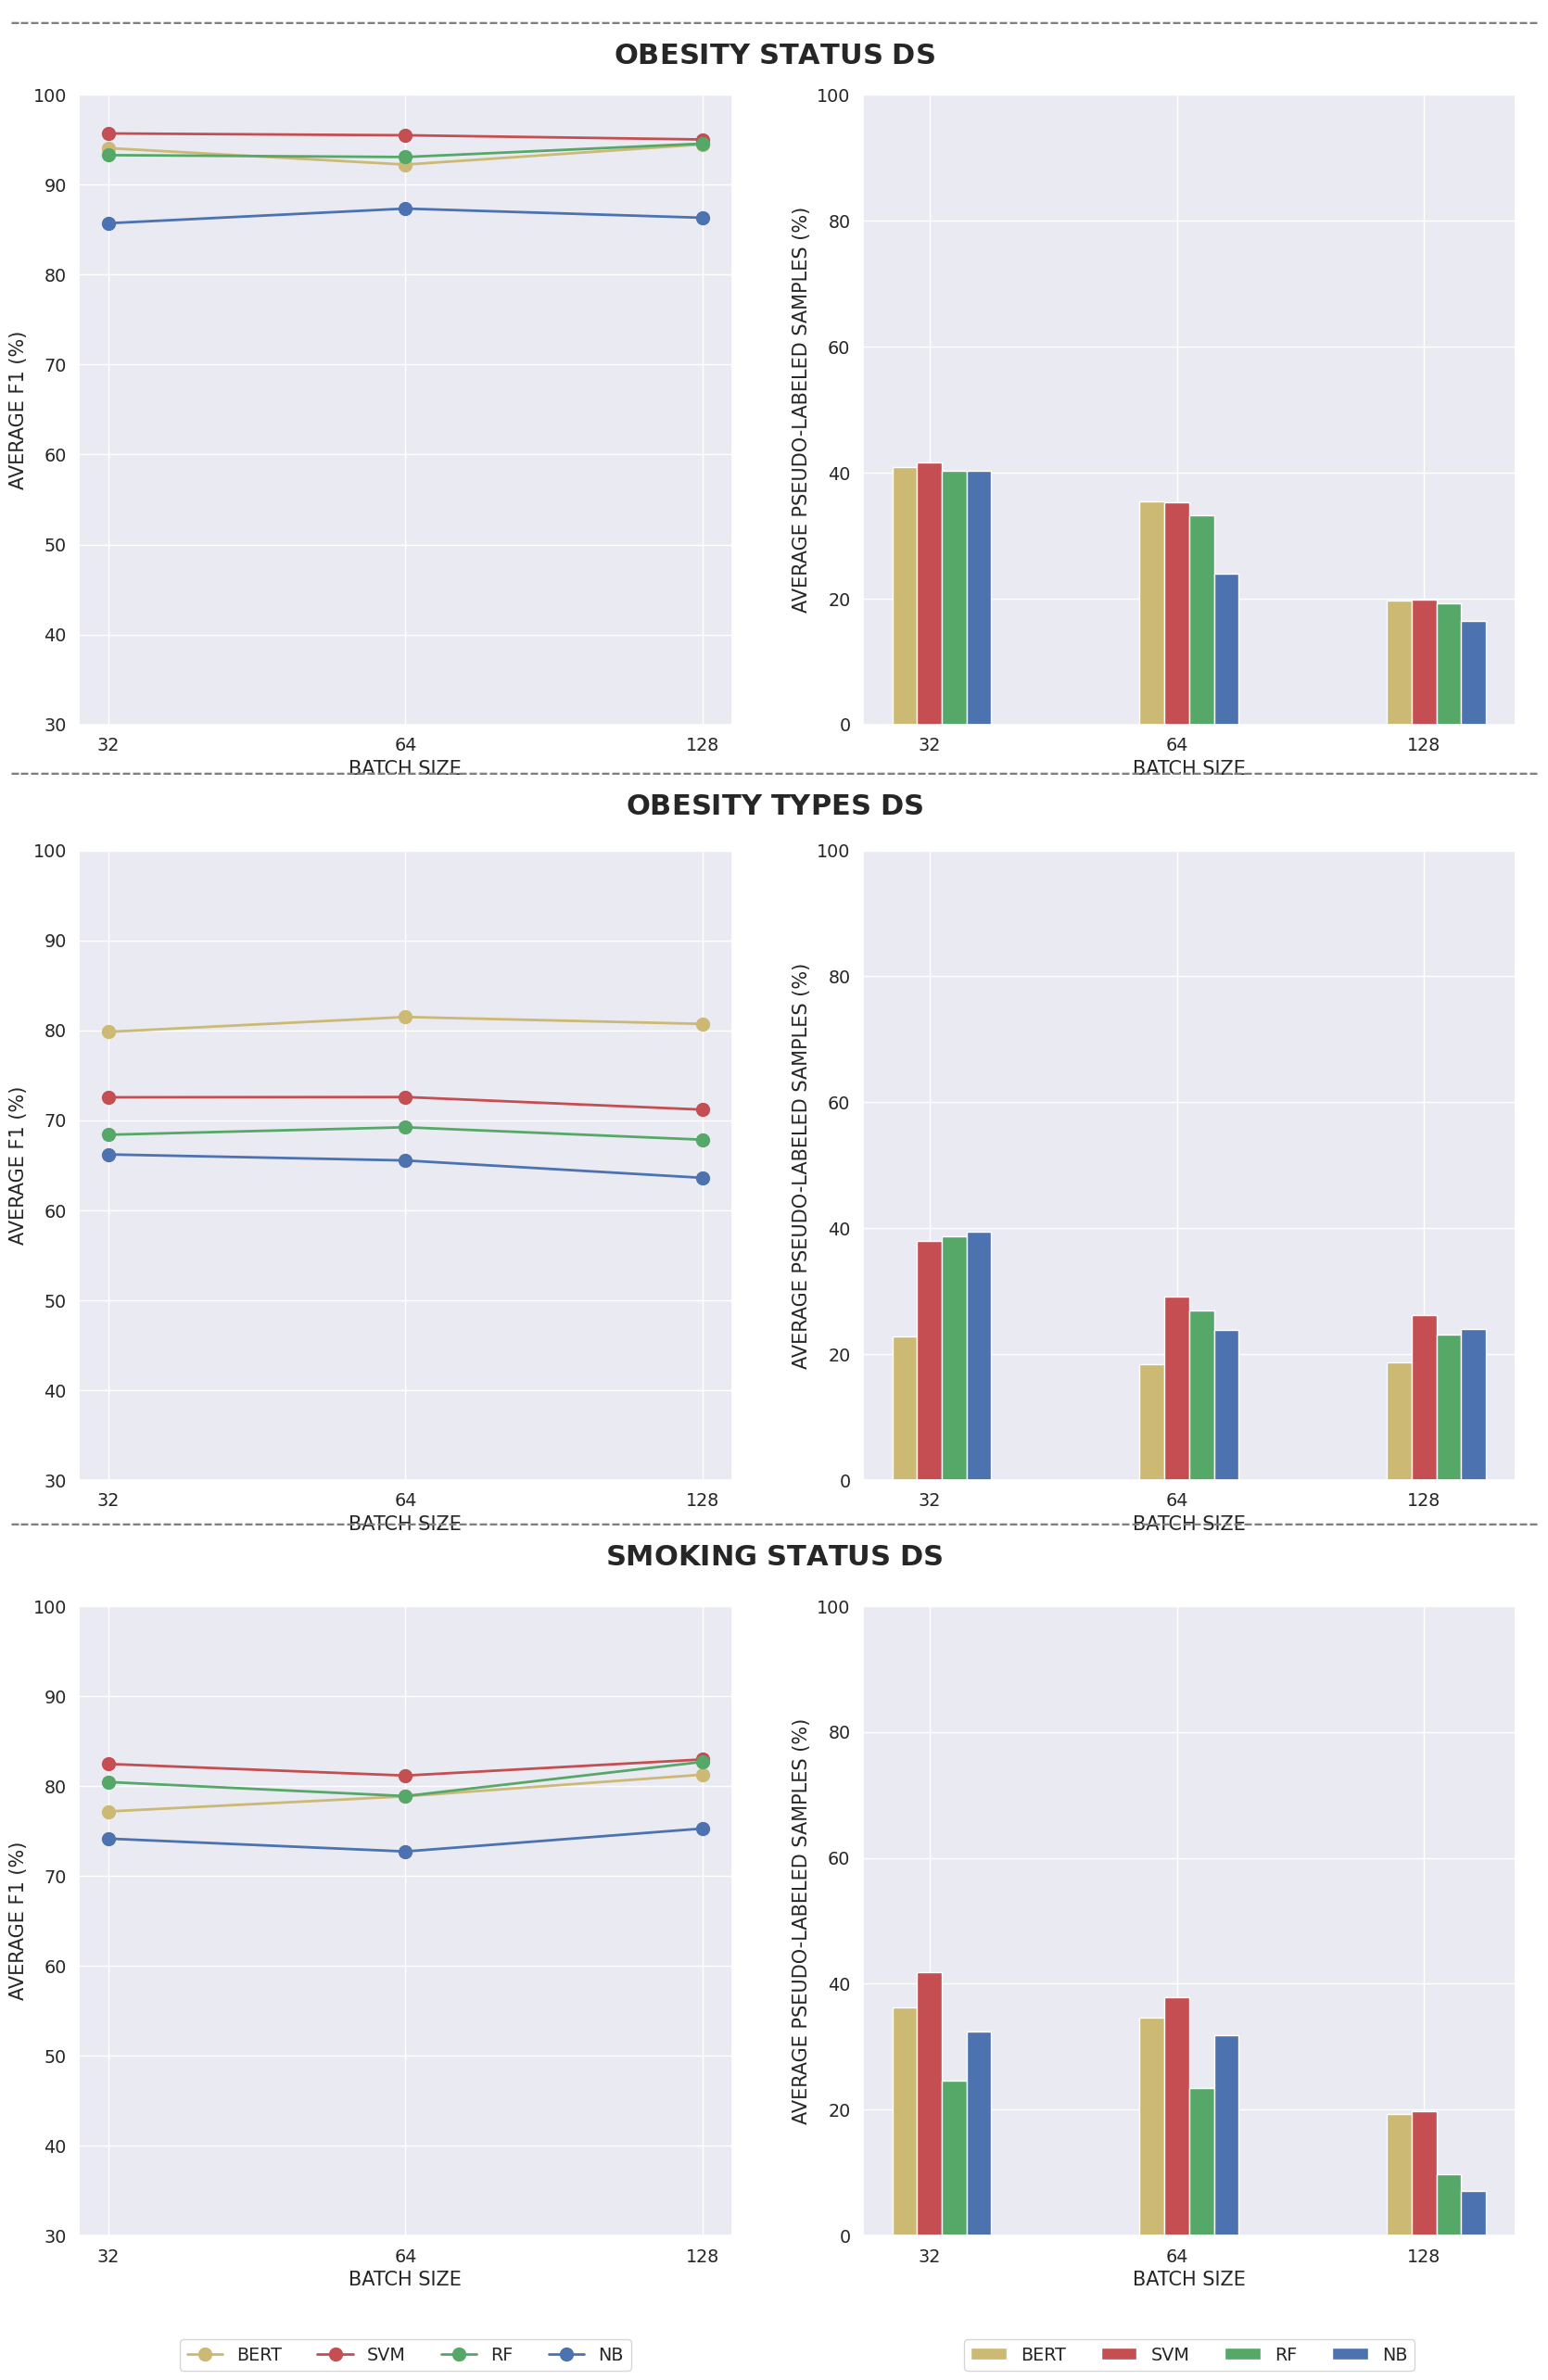

HGGB
batch_size
clfs
Perf bert [83.69 84.19 85.48]
Pseu bert [33.34 29.5  19.26]
Perf svm [83.56 83.08 83.05]
Pseu svm [40.47 34.08 21.93]
Perf rf [80.7  80.39 81.69]
Pseu rf [34.54 27.87 17.33]
Perf nb [75.35 75.2  75.06]
Pseu nb [37.35 26.52 15.83]
all
Perf: [80.83 80.71 81.32]
Pseu [36.42 29.49 18.59]


In [3]:
#Analysis
import os
import re
from matplotlib import pylab
import seaborn as sns
import matplotlib
import numpy as np
FONTSIZE = 15

sns.set_style("dark")
sns.set(font_scale=1.25)
matplotlib.rcParams.update({'font.size': FONTSIZE})
pylab.rcParams["legend.facecolor"] = "white"
pylab.rcParams['figure.facecolor'] = "white"

METRIC = 'F1' #F1 ACC

DATASET = 'HGGB'
FILENAMES = ['OBESIDAD', 'OBESIDAD_TIPOS', 'FUMADOR']
#DATASET = 'UCI'
#FILENAMES = ['AMAZON', 'IMDB', 'YELP']

curve_analysis = 'batch_size' #'batch_size' 'prob_thr'

if curve_analysis=='prob_thr':
  AUXS = [0.85, 0.9, 0.95]
  XLABEL = 'PROBABILITY THRESHOLD'
  legend = 'probability threshold'
elif curve_analysis=='batch_size':
  AUXS = [32,64,128]
  XLABEL = 'BATCH SIZE'
  legend = 'batch'

FILENAMES_ENG = {'OBESIDAD':'OBESITY STATUS',
                 'OBESIDAD_TIPOS': 'OBESITY TYPES',
                 'FUMADOR':'SMOKING STATUS',
                 'AMAZON':'AMAZON',
                 'IMDB': 'IMDB',
                 'YELP':'YELP'}

CLFS = ['bert', 'svm', 'rf', 'nb']
colors = {'bert':'y', 'svm': 'r', 'rf':'g', 'nb': 'b'}
ejey = {'OBESIDAD': 0.9, 'AMAZON':0.9,
        'OBESIDAD_TIPOS': 0.63, 'IMDB': 0.63,
        'FUMADOR': 0.36, 'YELP': 0.36
}

mean_perf = []
mean_pseu = []
mean_perf_dict = {'bert':[], 'svm':[], 'rf':[], 'nb':[]}
mean_pseu_dict = {'bert':[], 'svm':[], 'rf':[], 'nb':[]}

fig = pylab.figure(1, figsize=(20,30))
for filename in FILENAMES:
  performance = {'bert':[], 'svm':[], 'rf':[], 'nb':[]}
  pseudo = {'bert':[], 'svm':[], 'rf':[], 'nb':[]}


  for aux in AUXS:
    with open( os.path.join( os.getcwd(), 'texts', 'out', 'analysis', curve_analysis+'_'+str(aux)+'_'+DATASET+'_'+METRIC+'.txt' ), 'r'  ) as a:
      data = a.read().split('\n')[:-1]
      for clf in CLFS:
        for i in range(len(data)):
          if re.findall(r'^%s' %clf, data[i]) and re.findall(r'%s\s' %filename, data[i]):
            val = float( data[i].split(' ')[-1] )
            if (i%2)==0:
              pseudo[clf].append(val)
            else:
              performance[clf].append(val)


  W =150
  pylab.figtext(0.5, ejey[filename]+0.006, '-'*W, ha='center', va='center', fontsize=22, color='gray')
  pylab.figtext(0.5, ejey[filename]-0.006, r'$\bf{%s}~DS$' %FILENAMES_ENG[filename].replace(' ', '~'), ha='center', va='center', fontsize=22)

  pylab.subplot(3,2, 2*FILENAMES.index(filename)+1)
  mean_C = []
  for key in performance:
    pylab.plot( [0,1,2], performance[key],  colors[key]+'-o', lw=2, ms=10, label=key.upper())
    mean_C.append( performance[key] )
    mean_perf_dict[key].append( performance[key] )
  mean_C = np.mean(mean_C, axis=0)
  mean_perf.append(mean_C)

  pylab.xticks( [0,1,2], AUXS )
  pylab.xlabel(XLABEL)
  pylab.ylabel('AVERAGE '+METRIC+' (%)')
  pylab.ylim([30, 100])
  pylab.grid(True)

  if FILENAMES.index(filename) == len(FILENAMES)-1:
    pylab.legend( loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=False, ncol=4 )#, fontsize=FONTSIZE )

  pylab.subplot(3,2, 2*FILENAMES.index(filename)+2)
  mean_C = []
  eps = 0
  for key in pseudo:
    pylab.bar( np.array([0,1,2])+eps, pseudo[key],  color=colors[key], width=0.1, label=key.upper())
    eps+=0.1
    mean_C.append( pseudo[key] )
    mean_pseu_dict[key].append( pseudo[key] )

  mean_C = np.mean(mean_C, axis=0)
  mean_pseu.append(mean_C)
  pylab.xticks( np.array([0,1,2])+0.1, AUXS )
  pylab.xlabel(XLABEL)
  pylab.ylabel('AVERAGE PSEUDO-LABELED SAMPLES (%)')
  pylab.ylim([0, 100])
  pylab.grid(True)

  if FILENAMES.index(filename) == len(FILENAMES)-1:
    pylab.legend( loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=False, ncol=4 )#, fontsize=FONTSIZE )

pylab.show()

print(DATASET)
print(curve_analysis)
print('clfs')
for key in mean_pseu_dict:
  print( 'Perf', key, np.round(np.mean(np.array(mean_perf_dict[key]),axis=0 ),2) )
  print( 'Pseu', key, np.round(np.mean(np.array(mean_pseu_dict[key]),axis=0 ),2) )
print('all')
print( 'Perf:', np.round(np.mean(mean_perf, axis=0 ),2) )
print( 'Pseu', np.round(np.mean(mean_pseu, axis=0 ),2) )

RUNS: 1 FOLDS: 5 

AMAZON
bert
_lc_sslal_
bert 546.2 221.8 768 SSL-AL 28.88 & 71.12
_lc_al_
svm
_lc_sslal_
svm 501.2 266.8 768 SSL-AL 34.74 & 65.25999999999999
_lc_al_
rf
_lc_sslal_
rf 643.2 124.8 768 SSL-AL 16.25 & 83.75
_lc_al_
nb-multinomial
_lc_sslal_
nb-multinomial 727.2 40.8 768 SSL-AL 5.31 & 94.69
_lc_al_
bert
mean error: -0.3713501619180531
mean pseudo: 28.880208333333332
p-value<0.05 False
svm
mean error: -0.7379422425741305
mean pseudo: 34.739583333333336
p-value<0.05 False
rf
mean error: -0.5697507972628788
mean pseudo: 16.25
p-value<0.05 False
nb-multinomial
mean error: 0.1961705583791312
mean pseudo: 5.3125
p-value<0.05 False
+-------------+--------------------+------------------------------+------------------+-------------------+-----------------+---------------------------+---------------+----------------+
    0_F1(%)>= & 1_bert_lc_sslal_   & 1_nb-multinomial_lc_sslal_   & 1_rf_lc_sslal_   & 1_svm_lc_sslal_   & 2_bert_lc_al_   & 2_nb-multinomial_lc_al_   & 2_rf_lc_al_   

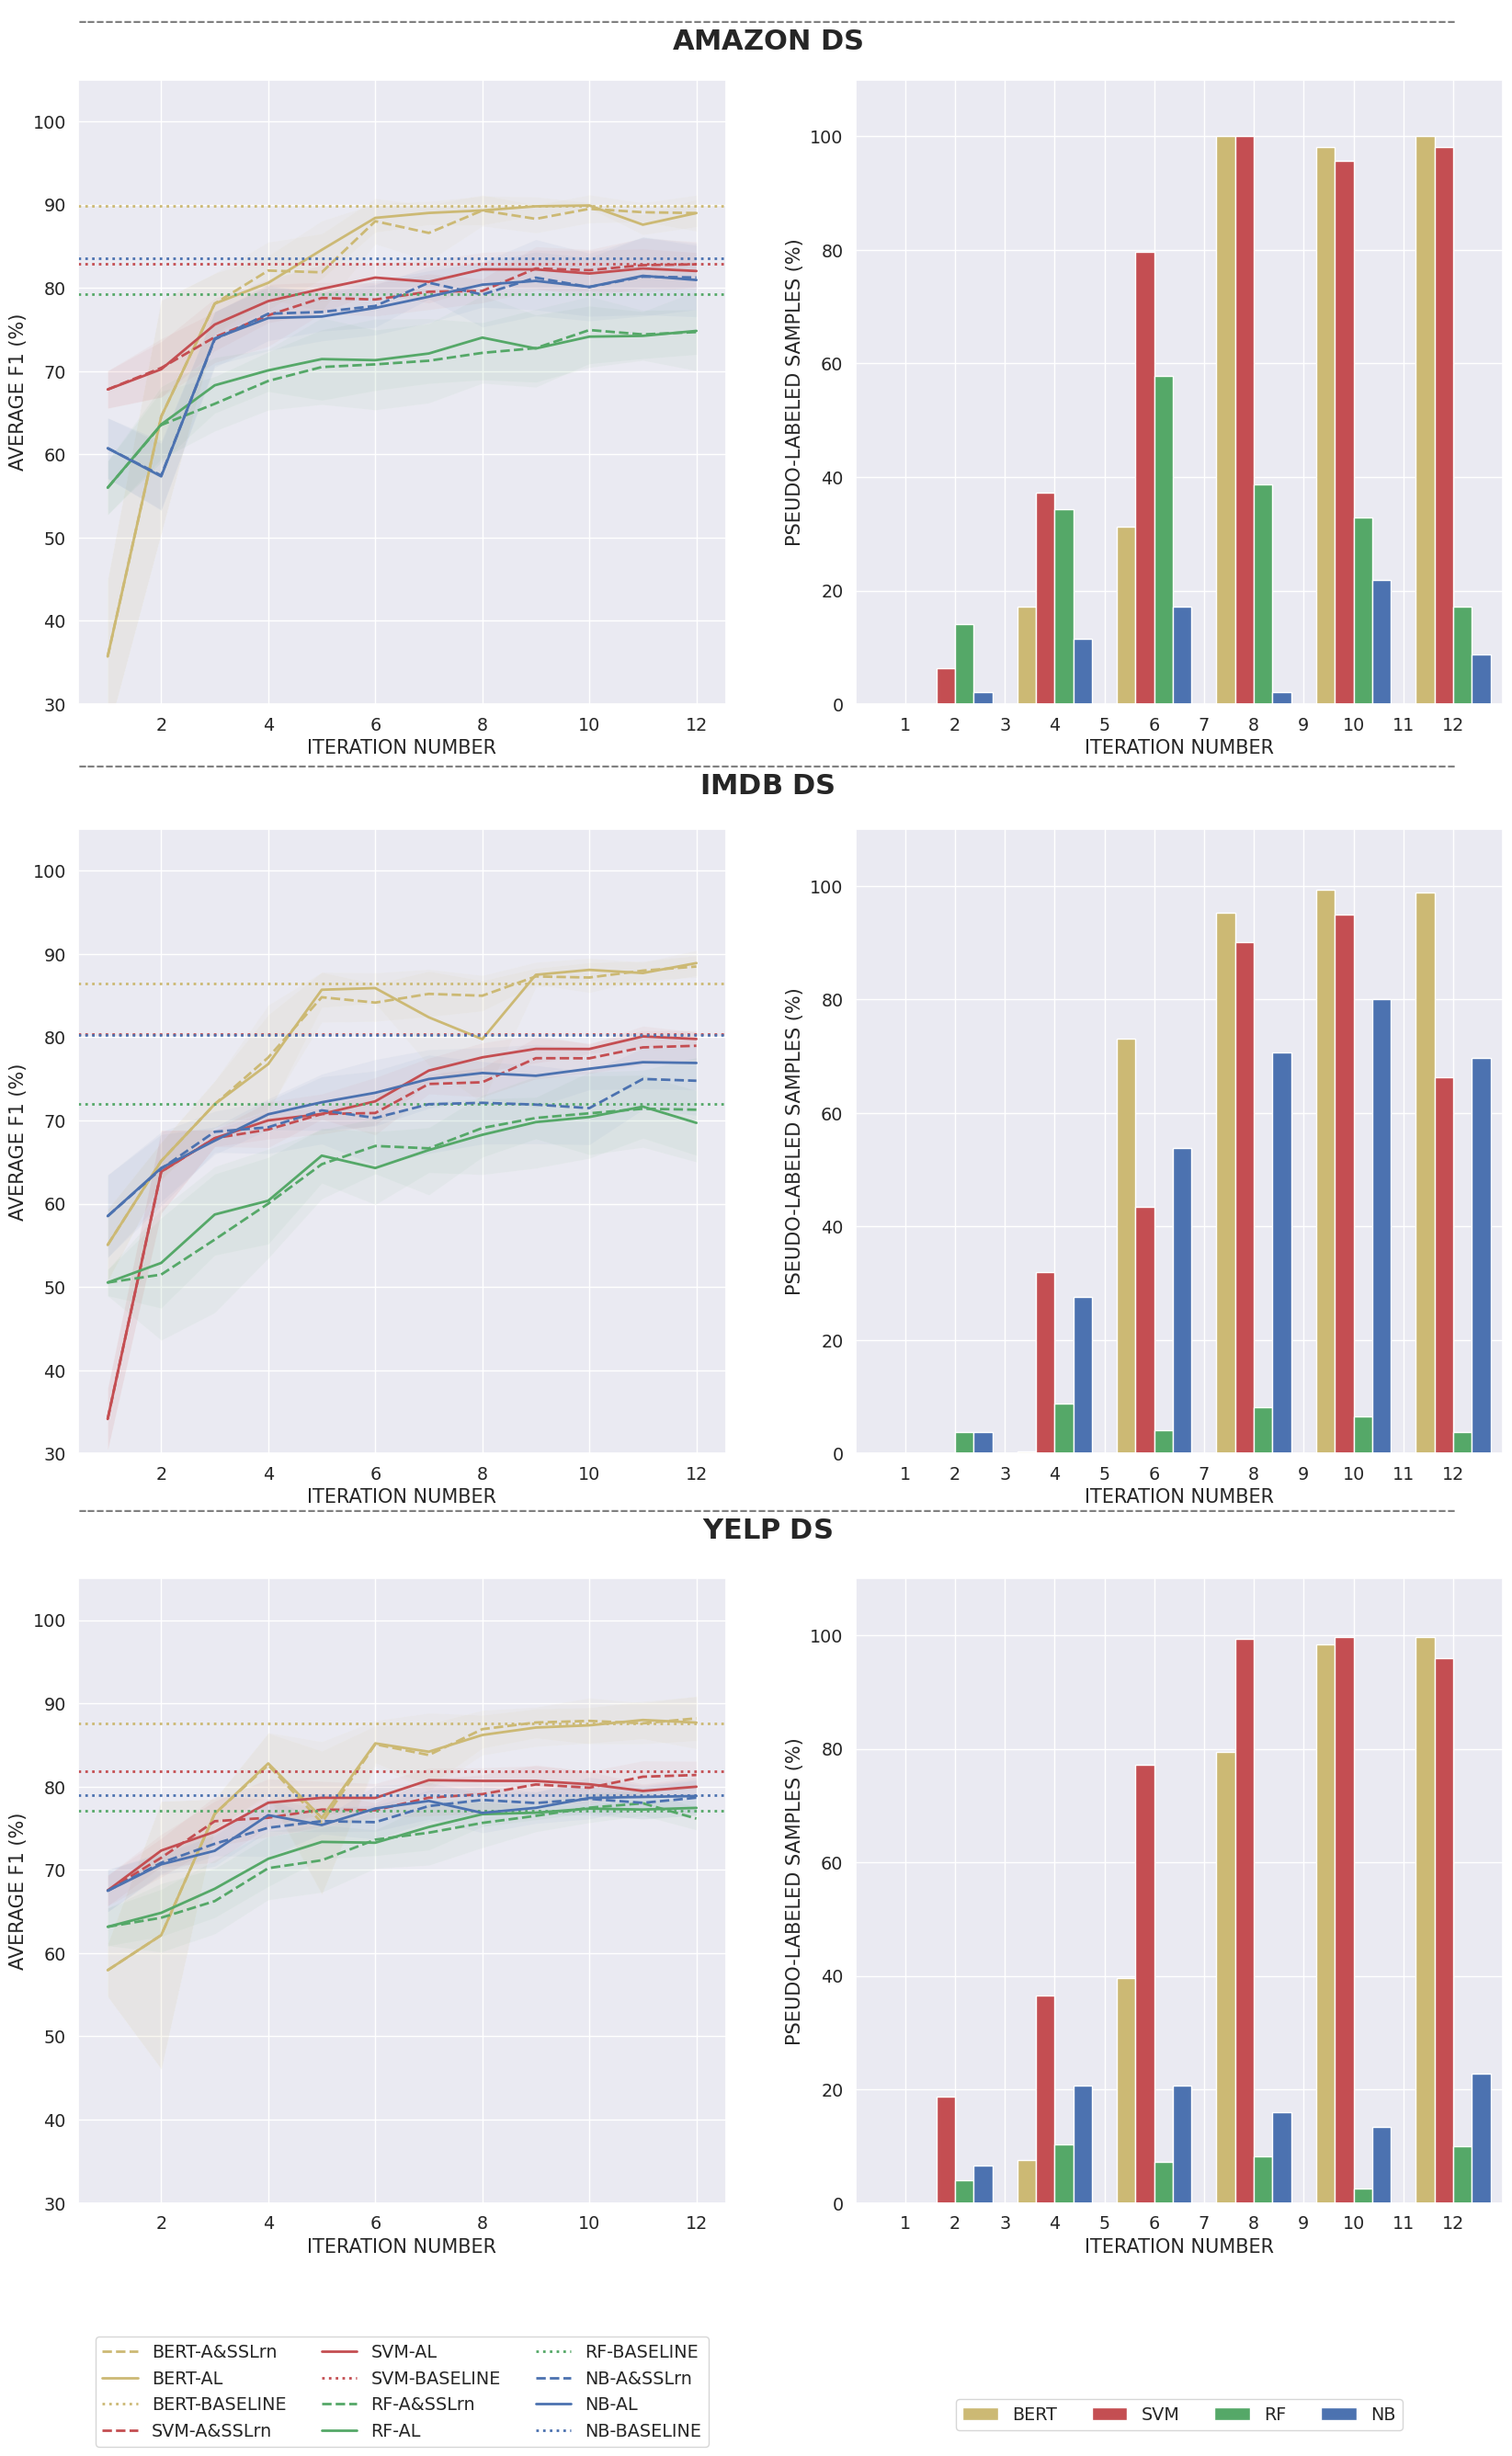

In [4]:
#Learning curves results
import warnings
warnings.filterwarnings("ignore")

import os
import pickle
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import matplotlib
from matplotlib import pylab
import seaborn as sns
import pandas as pd
from IPython.display import display
from tabulate import tabulate
from collections import Counter, defaultdict
import re
import copy
from scipy import stats
from scipy.stats import wilcoxon

sns.set_style("dark")
sns.set(font_scale=1.25)

SSL_TYPES = ['del-each-one'] #'all' 'add-each-one' 'del-each-one' 'del-clustering'

GRIDS = [True] #True False
PGES = [None] #0.05 0.1 None

DOMAIN = 'texts'
THR_PRB = 0.9
SAVE_TXT = False

#FILENAMES = ['OBESIDAD', 'OBESIDAD_TIPOS', 'FUMADOR']
#DATASET = 'HGGB'
FILENAMES = ['AMAZON', 'IMDB', 'YELP']
DATASET = 'UCI'

MODELS = ['bert', 'svm', 'rf', 'nb-multinomial']

CLASSES = {'OBESIDAD': 2, 'OBESIDAD_TIPOS':3, 'FUMADOR':2, 'AMAZON':2, 'IMDB':2, 'YELP':2}
batch_aux = 64 #32 64 128
BATCHES = {'OBESIDAD': batch_aux, 'OBESIDAD_TIPOS':batch_aux, 'FUMADOR':batch_aux, 'AMAZON':batch_aux, 'IMDB':batch_aux, 'YELP':batch_aux}
LABELS_CLASSES = {
           'OBESIDAD': ['NEGATIVE', 'POSITIVE'],
           'OBESIDAD_TIPOS':['MODERATE', 'SEVERE', 'MORBID'],
           'FUMADOR': ['NEGATIVE', 'POSITIVE'],
           'AMAZON': ['NEGATIVE', 'POSITIVE'],
           'IMDB': ['NEGATIVE', 'POSITIVE'],
           'YELP': ['NEGATIVE', 'POSITIVE']
           }

RUNS = 1
FOLDS = 5
METRIC = 'F1' #F1 ACC
FONTSIZE = 15
matplotlib.rcParams.update({'font.size': FONTSIZE})
pylab.rcParams["legend.facecolor"] = "white"
pylab.rcParams['figure.facecolor'] = "white"

ejey = {'OBESIDAD': 0.9, 'AMAZON':0.9,
        'OBESIDAD_TIPOS': 0.63, 'IMDB': 0.63,
        'FUMADOR': 0.36, 'YELP': 0.36
}

curve_analysis = None #None 'prob_thr' 'batch_size'

CURVES = {
          #primero ssl por axis
          'bert': ['_lc_sslal_', '_lc_al_'],
          'svm': ['_lc_sslal_', '_lc_al_'],
          'rf': ['_lc_sslal_', '_lc_al_'],
          'nb-multinomial': ['_lc_sslal_', '_lc_al_']
          }

if curve_analysis is not None:
  for key in CURVES:
    CURVES[key] = [ CURVES[key][0] ]

COLORS = {
          'bert_lc_al_': 'y-',
          'bert_lc_sslal_': 'y--',
          'svm_lc_al_': 'r-',
          'svm_lc_sslal_': 'r--',
          'rf_lc_al_': 'g-',
          'rf_lc_sslal_': 'g--',
          'nb-multinomial_lc_al_': 'b-',
          'nb-multinomial_lc_sslal_': 'b--'
}

COLORS_C = [ COLORS[key+'_lc_sslal_'][0]  for key in MODELS ]

LABELS = {
          'bert': 'BERT-BASELINE',
          'bert_lc_al_': 'BERT-AL',
          'bert_lc_sslal_': 'BERT-SSL',
          'svm': 'SVM-BASELINE',
          'svm_lc_al_': 'SVM-AL',
          'svm_lc_sslal_': 'SVM-SSL',
          'rf': 'RF-BASELINE',
          'rf_lc_al_': 'RF-AL',
          'rf_lc_sslal_': 'RF-SSL',
          'nb-multinomial': 'NB-BASELINE',
          'nb-multinomial_lc_al_': 'NB-AL',
          'nb-multinomial_lc_sslal_': 'NB-SSL'
          }
TITLES = {
          'OBESIDAD': 'OBESITY STATUS',
          'OBESIDAD_TIPOS': 'OBESITY TYPES',
          'FUMADOR': 'SMOKING STATUS',
          'AMAZON': 'AMAZON',
          'IMDB': 'IMDB',
          'YELP': 'YELP'
}

print('RUNS:', RUNS, 'FOLDS:', FOLDS, '\n')

if curve_analysis == 'batch_size':
  a_filename = open( os.path.join( os.getcwd(), 'texts', 'out', 'analysis', curve_analysis+'_'+str(batch_aux)+'_'+DATASET+'_'+METRIC+'.txt' ), 'w'  )
elif curve_analysis == 'prob_thr':
  a_filename = open( os.path.join( os.getcwd(), 'texts', 'out', 'analysis', curve_analysis+'_'+str(THR_PRB)+'_'+DATASET+'_'+METRIC+'.txt' ), 'w'  )

if SAVE_TXT:
  a_txt = open( os.path.join( os.getcwd(), DOMAIN, 'out', 'plots', DATASET, DATASET+'.txt' ) , 'w')
for SSL_TYPE in SSL_TYPES:
  if SAVE_TXT:
    a_txt.write('-'*30+'\n')
    a_txt.write('SSL_TYPE: '+SSL_TYPE+'\n')
  for GRID_PARAMS in GRIDS:
    if SAVE_TXT:
      a_txt.write('GRID_PARAMS: '+str(GRID_PARAMS)+'\n')
    for PGE in PGES:
      if SAVE_TXT:
        a_txt.write('PGE: '+str(PGE)+'\n')

      fig = pylab.figure(1, figsize=(20,30))
      idx = -1
      scores_lc = 'lc_al'

      average_all_cases = []
      average_all_cases_performance = []

      c_H_all = []
      c_C_all = []

      for FILENAME in FILENAMES:
        print(FILENAME)

        average_all_cases_clf = defaultdict(list)
        average_all_cases_performance_clf = defaultdict(list)

        mean_error = defaultdict(list)
        mean_pseudo = defaultdict(list)

        NCLASSES = CLASSES[FILENAME]
        BATCH = BATCHES[FILENAME]
        idx+=2

        curves_all = {}
        samples_model_curve = {}
        C_all = defaultdict(list)

        #with open( os.path.join( os.getcwd(), DOMAIN, 'out', 'RESULTS', FILENAME, FILENAME+'_baseline_results_p'+str(GRID_PARAMS)+'.pkl' ), 'rb') as a:
        #  baseline_results = pickle.load(a)

        for model in MODELS:
          print(model)

          if model != 'bert':
            GRID_PARAMS = True
          else:
            GRID_PARAMS = False

          with open( os.path.join( os.getcwd(), DOMAIN, 'out', 'RESULTS', FILENAME, FILENAME+'_baseline_results_p'+str(GRID_PARAMS)+'.pkl' ), 'rb') as a:
              baseline_results = pickle.load(a)

          A, B = [], []

          for curve in CURVES[model]:
            print(curve)

            #all
            curve_runs = []
            results_lc = defaultdict(list)

            if scores_lc in curve:
              scores_runs = []

            if 'lc_ssl' in curve:

              samples_runs = []
              distribution_runs = []
              p_qs = []
              p_val = []

            for r in range(RUNS):
              for k in range(FOLDS):
                if 'lc_ssl' not in curve:
                  with open( os.path.join( os.getcwd(), DOMAIN, 'out', 'BATCH'+str(BATCH), FILENAME, model, FILENAME+'_results'+curve+model+'_r'+str(r+1)+'_f'+str(k+1)+'_p'+str(GRID_PARAMS)+'.pkl' ), 'rb') as a:
                    results_lc_aux = pickle.load(a)
                else:
                  with open( os.path.join( os.getcwd(), DOMAIN, 'out', 'BATCH'+str(BATCH), 'PROB'+str(THR_PRB), FILENAME, model, FILENAME+'_results'+curve+model+'_r'+str(r+1)+'_f'+str(k+1)+'_p'+str(GRID_PARAMS)+'_'+SSL_TYPE+'_'+str(PGE)+'.pkl' ), 'rb') as a:
                    results_lc_aux = pickle.load(a)

                  results_lc_aux.pop(model+'_params')

                for key in results_lc_aux:
                  results_lc[key] += results_lc_aux[key]
                del results_lc_aux

              for f in range(FOLDS):

                #all
                curve_fold = []

                if scores_lc in curve:
                  scores_fold = []

                if 'lc_ssl' in curve:

                  samples_fold = []
                  distribution_fold = []
                  qs_fold = []
                  val_fold = []

                for key in results_lc:
                  true = None
                  if re.findall(r'^(AL|PL|SSL)', key):
                    true = results_lc[key][f][0]
                    for pred in results_lc[key][f][1]:
                      if METRIC == 'ACC':
                        curve_fold.append( 100*accuracy_score(true, pred) )
                      elif METRIC == 'F1':
                        curve_fold.append( 100*f1_score(true, pred, average='weighted') )
                  else:
                    if 'scores' in key:
                      x_axis = results_lc[key][f][0]

                    if 'scores' in key and scores_lc in curve:
                      for batch in results_lc[key][f][1]:
                        if len(batch)>0:
                          scores_fold.append( np.var(batch[:BATCH] ) )
                        else:
                          scores_fold.append(0)
                    elif 'samples' in key: #SSL-samples
                      samples_fold.extend( results_lc[key][f][1] )
                    elif 'distribution' in key:
                      for batch in results_lc[key][f][1]:
                        distribution_fold.append( Counter(batch) )
                    elif 'probs_val' in key: #select by batch
                      val_fold.extend( results_lc[key][f][1] )
                    elif 'probs_qs' in key:  #select by batch
                      qs_fold.extend( results_lc[key][f][1] )

                curve_runs.append( curve_fold )

                if scores_lc in curve:
                  scores_runs.append(scores_fold)

                if 'lc_ssl' in curve:

                  samples_runs.append( samples_fold )
                  distribution_runs.append( distribution_fold )
                  p_qs.append( qs_fold )
                  p_val.append( val_fold )

            ########################################################################
            max_points = max([len(p) for p in curve_runs])
            for idf in range(len(curve_runs)):
              if len(curve_runs[idf])<max_points:
                curve_runs[idf].append( curve_runs[idf][-1] )

                if scores_lc in curve:
                  scores_runs[idf].append( scores_runs[idf][-1] )
            ########################################################################

            curve_runs = np.array(curve_runs)
            error_curve_runs = np.std(curve_runs, axis = 0)
            curve_runs = np.mean(curve_runs, axis=0)

            if scores_lc in curve:
              scores_runs = np.array(scores_runs)
              scores_runs = np.mean(scores_runs, axis=0)

            if 'lc_ssl' in curve:

              A = copy.deepcopy(curve_runs)

              ########################################################################
              max_points = max([len(p) for p in samples_runs])
              for idf in range(len(samples_runs)):
                if len(samples_runs[idf])<max_points:
                  samples_runs[idf].append( samples_runs[idf][-1] )
                  #just for obesity
                  distribution_runs[idf].append( {'C':0, 'H':1} )
              ########################################################################

              samples_runs = np.array(samples_runs)
              samples_runs = np.mean(samples_runs, axis=0)
              samples_model_curve[model+curve] = samples_runs

              c_H = 0
              c_C = 0
              for p in range(len(samples_runs)):
                C_all[ re.sub(r'\-\w+$', '', model).upper() ].append([])
                for f in range(FOLDS):
                  H_aux = distribution_runs[f][p]['H']
                  C_aux = distribution_runs[f][p]['C']
                  C_all[ re.sub(r'\-\w+$', '', model).upper() ][p].append( 100*C_aux/(H_aux+C_aux) )

                  average_all_cases_clf[model+'_'+FILENAME].append( 100*C_aux/(H_aux+C_aux) )

                  mean_pseudo[model].append( 100*C_aux/(H_aux+C_aux) )

                  c_H += H_aux
                  c_C += C_aux

              c_H /= (RUNS*FOLDS)
              c_C /= (RUNS*FOLDS)

              c_H_all.append( 100*c_H/x_axis[-1] )
              c_C_all.append( 100*c_C/x_axis[-1] )

              print( model, c_H, c_C, x_axis[-1], 'SSL-AL', round(100*c_C/x_axis[-1], 2), '&', 100-round(100*c_C/x_axis[-1], 2) )

            elif 'lc_al' in curve:
              B = copy.deepcopy(curve_runs)

            ax = pylab.subplot(len(FILENAMES), 2, idx)

            mean_error[model].append( curve_runs )

            pylab.plot(np.arange(len(x_axis))+1, curve_runs, COLORS[model+curve], label = LABELS[model+curve].replace('SSL', 'A&SSLrn'), lw=2 )

            if 'lc_ssl' in curve:
              average_all_cases_performance.append( np.mean(curve_runs) )
              average_all_cases_performance_clf[model+'_'+FILENAME].append( np.mean(curve_runs) )

            #baseline
            if '_al_' in curve:
              pylab.axhline( baseline_results[model+'_'+METRIC.lower()], c=COLORS[model+curve][0], linestyle = ':', label = LABELS[model], lw=2 )

            pylab.fill_between(np.arange(len(x_axis))+1, curve_runs-error_curve_runs, curve_runs+error_curve_runs, facecolor=COLORS[model+curve][0],  alpha=0.05)
            pylab.grid(True)
            pylab.xlabel('Iteration number'.upper() )
            pylab.ylabel( ('Average '+METRIC+' (%)').upper() )
            pylab.ylim([30, 105])
            if idx == len(FILENAMES):

              pylab.legend( loc='upper center', bbox_to_anchor=(0.5, -1.4), shadow=False, ncol=3 )

            curves_all[model+curve] = curve_runs

        W = 150

        pylab.figtext(0.5, ejey[FILENAME]+0.001, '-'*W, ha='center', va='center', fontsize=20, color='gray')
        pylab.figtext(0.5, ejey[FILENAME]-0.006, r'$\bf{%s~DS}$' %TITLES[FILENAME].replace(' ', '~'), ha='center', va='center', fontsize=22)

        labels = np.arange(0, len(x_axis))
        C_all_average = {}
        average_C = []
        for keyC in C_all:
          array_aux = copy.deepcopy( np.array(C_all[keyC]) )
          C_all_average[keyC] = np.mean(array_aux, axis=1)
          average_C.append(C_all_average[keyC])
          average_all_cases.extend(np.mean(array_aux, axis=1))

        df = pd.DataFrame( C_all_average, index=labels)

        ax = pylab.subplot(len(FILENAMES), 2, idx+1)

        df.plot(kind='bar', ax=ax, stacked=False, legend=False, color=COLORS_C, width=1.5)
        pylab.xlabel('Iteration number'.upper() )
        pylab.ylabel('Pseudo-labeled samples (%)'.upper() )
        pylab.ylim( [0, 110] )
        pylab.xticks( np.arange(len(x_axis)), np.arange(len(x_axis))+1, rotation=0 )
        pylab.grid(True)

        if idx == len(FILENAMES):
          pylab.legend( loc='upper center', bbox_to_anchor=(0.5, -1.5), shadow=False, ncol=5 )

        if curve_analysis is not None:
          for key_c in average_all_cases_performance_clf:
            a_filename.write(key_c+' '+str( np.round( np.mean(average_all_cases_clf[key_c]),2 ) )+'\n')
            a_filename.write(key_c+' '+str( np.round( np.mean(average_all_cases_performance_clf[key_c]),2 ) )+'\n')

        if curve_analysis is None:
          for key_m in mean_error:

            ssl_curve_error,  al_curve_error = mean_error[key_m]
            ssl_curve_error = np.array(ssl_curve_error)
            al_curve_error = np.array(al_curve_error)
            l_error = len(ssl_curve_error)

            print(key_m)
            print( 'mean error:', (ssl_curve_error-al_curve_error).sum()/l_error )
            print( 'mean pseudo:', np.mean(mean_pseudo[key_m]) )
            print('p-value<0.05', wilcoxon(ssl_curve_error, al_curve_error)[1]<0.05 )

        values = range(60,100)
        columns_df = []
        x_y_curves = {'0_'+METRIC.upper()+'(%)>=': values}
        for key in curves_all:
          x_y = []
          results_lc = copy.deepcopy( curves_all[key] )
          for val in values:
            xy = '-'
            for index in range(len(x_axis)):
              if results_lc[index]>=val and xy=='-':
                if 'ssl' not in key:
                  xy = x_axis[index]
                else:
                  xy = int(samples_model_curve[key][index])
            x_y.append(xy)
          if '_al_' in key:
            key_aux_df = '2_'+key
          elif '_sslal_' in key:
            key_aux_df = '1_'+key
          columns_df.append( key_aux_df )
          x_y_curves[key_aux_df] = x_y
        columns_df.append('0_'+METRIC.upper()+'(%)>=')
        columns_df = sorted(columns_df)
        df = pd.DataFrame.from_dict(x_y_curves)
        df = df[columns_df]

        table_df = tabulate(df, headers = 'keys', tablefmt = 'psql', showindex=False).replace('|', '&')
        table_df = re.sub(r'^\&', ' ', table_df, flags=re.M)
        table_df = re.sub(r'\&$', r'\\\\ \\hline', table_df, flags=re.M)
        print ( table_df )

        with open( os.path.join( os.getcwd(), DOMAIN, 'out', 'plots', DATASET, 'Tables', FILENAME+'_SSL_'+SSL_TYPE+'_GRID_'+str(GRID_PARAMS)+'_PGE_'+str(PGE)+'.txt' ), 'w' ) as a:
          a.write( tabulate(df, headers = 'keys', tablefmt = 'psql') )

      print(  'SSL-AL (all)', round( np.mean(c_C_all), 2), '&', 100-round( np.mean(c_C_all), 2) )
      print( 'average samples:', np.mean(average_all_cases) )
      print( 'average acc (%):', np.mean(average_all_cases_performance) )

      pylab.savefig( os.path.join( os.getcwd(), DOMAIN, 'out', 'plots', DATASET, 'Figures', '-'.join(FILENAMES)+'_SSL_'+SSL_TYPE+'_GRID_'+str(GRID_PARAMS)+'_PGE_'+str(PGE)+'.png' ), bbox_inches='tight' )
      pylab.show()

      del fig

      if SAVE_TXT:
        a_txt.write('Average (% anotacion): '+str(np.round(np.mean(average_all_cases),2))+'\n')
        a_txt.write('Average (% acc): '+str(np.round(np.mean(average_all_cases_performance),2))+'\n')
        a_txt.write('-'*30+'\n')

if SAVE_TXT:
  a_txt.close()

if curve_analysis is not None:
  a_filename.close()
